In [372]:
import numpy as np
import jax.random
import jax.numpy as jnp
import jax.scipy.optimize
import jaxopt
import optax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from shapely.geometry import Polygon, Point
from functools import partial

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.ioff()

import time
import pandas as pd
from datetime import datetime
import os
import pytz
import ast
from pypdf import PdfMerger

import contextlib
import warnings
warnings.filterwarnings('ignore')

In [373]:
# Running parameters
num_iters = 1000    # Number of training iterations
num_runs = 10
cl_types = ["NCL", "CL", "ACL", "SPCL", "SPACL"]     # "NCL" - No curriculum, "CL" - Curriculum, "ACL" - Anti-curriculum, "SPCL" - Self paced curriculum, "SPACL" - Self paced anti-curriculum
with_val = True

# Circuit and optimization parameters
nqubits = 8         # Num qubits, min 4, always 2**num_layers qubits
with_bias = False    # Add a bias to the output of the quantum circuit
optimizer = "Adam"  # "Adam", "GradientDescent", "BFGS"
loss_type = "mean_squares" # "cross_entropy", "mean_squares"
initialization = "gaussian" # "gaussian", "uniform"

# Data hyper-parameters
batch_size = 100     # batch training size
train_size = 100      # Total ground states that will be used for training
val_size = 1000      # Total gound states with training + validation
cl_batch_ratios = [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]  #[0.4, 0.3, 0.2, 0.1]    # [0.1, 0.2, 0.3, 0.4], [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [0.3, 0.2, 0.2, 0.2, 0.1]
cl_iter_ratios  = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2]

# How the training data is generated
uniform_train = False    # True - Uniform, False - Balanced
uniform_val = False
epsilon_train = True   # True - epsilon, False - no epsilon
epsilon_val = False

# Tweak training hyper-parameters
max_weight_init = 2*np.pi  # weight_init goes from 0 to this number. Max = 2*np.pi. Other options = 0.01
stepsize = 0.01         # stepsize of the gradient descent.

# Constant definitions
layers = int(np.log2(nqubits))
nweights = 30*(layers-1) + 15

cl_batches = []
i_batch_size = 0
for i in range(len(cl_iter_ratios)):
    if i < len(cl_iter_ratios)-1:
        i_batch_size += int(cl_batch_ratios[i]*train_size)
        i_num_iters = int(cl_iter_ratios[i]*num_iters)
    else:
        i_batch_size = train_size
        i_num_iters = num_iters - len(cl_batches)
        
    cl_batches += [i_batch_size]*i_num_iters

# Ground states

In [374]:
def X(i):
    return qml.PauliX(i)

def Z(i):
    return qml.PauliZ(i)

In [375]:
@jax.jit
def ground_state(j1, j2):
    
    hamiltonian = 0
    for i in range(nqubits):
        hamiltonian += Z(i)
        hamiltonian -= j1 * X(i) @ X((i+1)%nqubits)
        hamiltonian -= j2 * X((i-1)%nqubits) @ Z(i) @ X((i+1)%nqubits)
    
    ham_matrix = qml.matrix(hamiltonian)
    _, eigvecs = jnp.linalg.eigh(ham_matrix)
    
    return eigvecs[:,0]

In [376]:
# Define coordinates of the points of each region# Definir las coordenadas de los puntos de cada región
region01_coords = np.array([(-2, 1), (2, 1), (4, 3), (4, 4), (-4, 4), (-4, 3)])    # Class 0
region02_coords = np.array([(-3, -4), (0, -1), (3, -4)])                           # Class 0
region1_coords = np.array([(0, -1), (3, -4), (4, -4), (4, 3)])                     # Class 1
region2_coords = np.array([(0, -1), (-3, -4), (-4, -4), (-4, 3)])                  # Class 2
region3_coords = np.array([(-2, 1), (2, 1), (0, -1)])                              # Class 3

e = 0.1
# Define coordinates of the points of each region far from the borders
region01e_coords = np.array([(-2+(np.sqrt(2)-1)*e, 1+e), (2-(np.sqrt(2)-1)*e, 1+e), (4, 3+np.sqrt(2)*e), (4, 4), (-4, 4), (-4, 3+np.sqrt(2)*e)])    # Class 0 with epsilon
region02e_coords = np.array([(-3+np.sqrt(2)*e, -4), (0, -1-np.sqrt(2)*e), (3-np.sqrt(2)*e, -4)])                                                    # Class 0 with epsilon
region1e_coords = np.array([(0+np.sqrt(2)*e, -1), (3+np.sqrt(2)*e, -4), (4, -4), (4, 3-np.sqrt(2)*e)])                                              # Class 1 with epsilon
region2e_coords = np.array([(0-np.sqrt(2)*e, -1), (-3-np.sqrt(2)*e, -4), (-4, -4), (-4, 3-np.sqrt(2)*e)])                                           # Class 2 with epsilon
region3e_coords = np.array([(-2+e/np.tan(np.pi/8), 1-e), (2-e/np.tan(np.pi/8), 1-e), (0, -1+np.sqrt(2)*e)])                                         # Class 3 with epsilon


def labeling(x, y):

    # Create Polygons for each region
    region01_poly = Polygon(region01_coords)
    region02_poly = Polygon(region02_coords)
    region1_poly = Polygon(region1_coords)
    region2_poly = Polygon(region2_coords)
    region3_poly = Polygon(region3_coords)
    
    p = Point(x, y)
    if region01_poly.contains(p):
        return 0
    elif region02_poly.contains(p):
        return 0
    elif region1_poly.contains(p):
        return 1
    elif region2_poly.contains(p):
        return 2
    elif region3_poly.contains(p):
        return 3
    else:
        return None # if the point is not in any region
    
    
def labeling_epsilon(x, y):
    
    # Create Polygons for each region
    region01e_poly = Polygon(region01e_coords)
    region02e_poly = Polygon(region02e_coords)
    region1e_poly = Polygon(region1e_coords)
    region2e_poly = Polygon(region2e_coords)
    region3e_poly = Polygon(region3e_coords)
    
    p = Point(x, y)
    if region01e_poly.contains(p):
        return 0
    elif region02e_poly.contains(p):
        return 0
    elif region1e_poly.contains(p):
        return 1
    elif region2e_poly.contains(p):
        return 2
    elif region3e_poly.contains(p):
        return 3
    else:
        return None # if the point is not in any region

In [377]:
# Generate ground states
def generate_gs(num_points, uniform, epsilon):
    
    if uniform: # Sample the ground states uniformly from the j's space
        if epsilon:
            j_list = []
            num = 0
            while num < num_points:
                j = np.random.uniform(-4, 4, 2)
                l = labeling_epsilon(j[0], j[1])

                if l in [0,1,2,3]:
                    num += 1
                    j_list.append(j)

            j_list = np.array(j_list)
            
        else:
            j_list = np.random.uniform(-4, 4, (num_points,2))
    
    
    else: # Sample the same number of ground states for each class
        npoints_class = num_points//4
        npoints_02 = npoints_class//2
        npoints_01 = npoints_class - npoints_02 + num_points%4
        
        # This would be another definition of balanced, with the same number of points per area (so class 0 has double points)
        ## npoints_class = num_points//5
        ## npoints_02 = npoints_class
        ## npoints_01 = npoints_class + num_points%4
        
        
        
        j_list = []
        num_01, num_02, num_1, num_2, num_3 = 0, 0, 0, 0, 0
        
        while num_01 != npoints_01 or num_02 != npoints_02 or num_1 != npoints_class or num_2 != npoints_class or num_3 != npoints_class:
            j = np.random.uniform(-4, 4, 2)
            l = labeling_epsilon(j[0], j[1]) if epsilon else labeling(j[0], j[1])

            if l==0:
                
                p = Point(j[0], j[1])
                if Polygon(region01_coords).contains(p) and num_01 < npoints_01:
                    num_01 += 1
                    j_list.append(j)
                    
                elif Polygon(region02_coords).contains(p) and num_02 < npoints_02:
                    num_02 += 1
                    j_list.append(j)
                
            elif l==1 and num_1 < npoints_class:
                num_1 += 1
                j_list.append(j)
            elif l==2 and num_2 < npoints_class:
                num_2 += 1
                j_list.append(j)
            elif l==3 and num_3 < npoints_class:
                num_3 += 1
                j_list.append(j)

        j_list = np.array(j_list)
    
    
    gs_list = jax.vmap(ground_state, in_axes=[0,0])(j_list[:,0], j_list[:,1])
    
    labels_list = []
    for i in range(num_points):
        labels_list.append(labeling(j_list[i,0], j_list[i,1]))
    
    gs_list = np.array(gs_list)
    labels_list = np.array(labels_list)
    
    return gs_list, labels_list, j_list

# CNN

In [378]:
def convolutional_layer(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])

def pooling_layer(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])

In [379]:
def cnn_circuit(weights, state_ini):
    
    qubits = list(range(nqubits))
    
    qml.QubitStateVector(state_ini, wires=qubits)

    for j in range(layers-1):
        
        len_qubits = len(qubits)
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[15*2*j:15*(2*j+1)])
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i+1], qubits[(2*i+2)%len_qubits], weights[15*2*j:15*(2*j+1)])
            
        for i in range(len_qubits//2):
            pooling_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[15*(2*j+1):15*(2*j+2)])

        qub = []
        for i in range(len_qubits):
            if i%2 == 1:
                qub.append(qubits[i])
                
        qubits = qub
    
    convolutional_layer(qubits[0], qubits[1], weights[15*(2*layers-2):15*(2*layers-1)])
    
    return qml.expval(Z(qubits[0])), qml.expval(Z(qubits[1])), qml.expval(Z(qubits[0]) @ Z(qubits[1]))

# dev_draw = qml.device("qiskit.aer", wires=nqubits)
dev = qml.device("default.qubit", wires=nqubits)

# cnn_draw = qml.QNode(cnn_circuit, dev_draw)
cnn_circuit = qml.QNode(cnn_circuit, dev, interface="jax", diff_method="best")


def cnn(weights, state_ini):
    z0, z1, zz01 = cnn_circuit(weights, state_ini)

    proj_00 = (1+zz01+z0+z1)/4
    proj_01 = (1-zz01-z0+z1)/4
    proj_10 = (1-zz01+z0-z1)/4
    proj_11 = (1+zz01-z0-z1)/4

    return jnp.array([proj_00, proj_01, proj_10, proj_11])

In [380]:
@jax.jit
def variational_classifier(weights, bias, state_ini):
    return cnn(weights, state_ini) + bias

In [381]:
# draw circuit

# weights = np.random.uniform(0, 2*np.pi, nweights)
# drawer = qml.draw(cnn_circuit)
# print(drawer(weights, gs_list[0]))

# z0, z1, zz01 = cnn_draw(gs_list[0], weights)
# print(z0, z1, zz01)
# dev_draw._circuit.draw(output="mpl")

# Loss and accuracy

In [382]:
@jax.jit
def single_loss(weights, bias, ground_state, label):
    
    proj = variational_classifier(weights, bias, ground_state)

    if loss_type == "cross_entropy":
        cost = -jnp.log2(proj[label])
    
    elif loss_type == "mean_squares":
        cost = 1 + jnp.linalg.norm(proj)**2 - 2*proj[label]
    
    return cost


if with_bias:
    @jax.jit
    def loss(weights_and_bias, ground_states, labels):
        costs = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(weights_and_bias[0], weights_and_bias[1], ground_states, labels)
        return costs.sum()/len(labels)
    
else:
    @jax.jit
    def loss(weights, ground_states, labels):
        costs = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(weights, np.array([0.0]*4), ground_states, labels)
        return costs.sum()/len(labels)

In [383]:
@jax.jit
def single_pred(weights, bias, ground_state):
    projectors = variational_classifier(weights, bias, ground_state)
    return np.argmax(projectors)

@jax.jit
def pred(weights, bias, ground_states):
    predictions = jax.vmap(single_pred, in_axes=[None, None, 0])(weights, bias, ground_states)
    return predictions

@jax.jit
def acc(predictions, labels):
    return sum(predictions==labels)*100/len(labels)

# Processing Data

In [384]:
def save_multi_image(filename):
    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

def close_all_figures():
    fig_nums = plt.get_fignums()
    for n in fig_nums:
        plt.figure(n)
        plt.close()

        
def save_plots(time_now,
               folder_name,
               file_name,
               plot_run,
               it_max,
               acc_train,
               acc_val,
               losses,
               pred_train,
               pred_val,
               j_train,
               j_val
              ):


    fig, axis = plt.subplots(1,3)
    fig.set_figheight(6.5)
    fig.set_figwidth(20)
    fig.tight_layout(pad=2, w_pad=3.5)

    # ---------------------------------------------------------------------- #
    # -------------------- Loss and accuracy figure ------------------------ #
    # ---------------------------------------------------------------------- #

    iterations = range(1, num_iters+1)

    color1 = 'darkred'
    axis[0].set_xlabel('Iterations')
    axis[0].set_ylabel('Accuracy %', color=color1)
    axis[0].plot(iterations, acc_train, label="Training", color=color1)
    axis[0].plot(iterations, acc_val, '-.', label="Validation", color=color1)
    axis[0].tick_params(axis='y', labelcolor=color1)
    axis[0].set_ylim(0,100)

    ax2 = axis[0].twinx()  # instantiate a second axes that shares the same x-axis

    color2 = 'darkblue'
    ax2.set_ylabel('Loss', color=color2)  # we already handled the x-label with axis[0]
    ax2.plot(iterations, losses, label="Loss", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    # ax2.set_ylim(bottom=0)

    # fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.legend()
    axis[0].set_title(f"Accuracy and Loss - Run {plot_run}")


    # ----------------------------------------------------------------------------- #
    # ---------------------------- Training points -------------------------------- #
    # ----------------------------------------------------------------------------- #

    plot_iter = num_iters-1

    # define regions coordinates
    x01, y01 = region01_coords[:,0], region01_coords[:,1]
    x02, y02 = region02_coords[:,0], region02_coords[:,1]
    x1, y1 = region1_coords[:,0], region1_coords[:,1]
    x2, y2 = region2_coords[:,0], region2_coords[:,1]
    x3, y3 = region3_coords[:,0], region3_coords[:,1]

    # put the regions into the plot
    axis[1].fill(x01, y01, facecolor='lightskyblue')    # class 0
    axis[1].fill(x02, y02, facecolor='lightskyblue')    # class 0
    axis[1].fill(x1, y1, facecolor='sandybrown')        # class 1
    axis[1].fill(x2, y2, facecolor='salmon')            # class 2
    axis[1].fill(x3, y3, facecolor='lightgreen')        # class 3

    pred_train_plot = np.array(pred_train[plot_iter])
    pred_val_plot = np.array(pred_val[plot_iter])

    colors = ["b", "orange", "r", "g"]

    # plot datapoints
    for i in range(4):
        axis[1].scatter(
            j_train[:, 0][pred_train_plot==i],
            j_train[:, 1][pred_train_plot==i],
            c=colors[i],
            marker="o",
            edgecolors="k",
            label=f"class {i+1} train",
        )
        # if with_val:
        #     axis[1].scatter(
        #         j_val[:, 0][pred_val_plot==i],
        #         j_val[:, 1][pred_val_plot==i],
        #         c=colors[i],
        #         marker="^",
        #         edgecolors="k",
        #         label=f"class {i+1} validation",
        #     )


    # plt.legend()
    axis[1].set_title(f"Training ({acc_train[plot_iter]:.0f}%)")


    # ------------------------------------------------------------------------------ #
    # ---------------------------- Validation points ------------------------------- #
    # ------------------------------------------------------------------------------ #


    plot_iter = num_iters-1

    # define regions coordinates
    x01, y01 = region01_coords[:,0], region01_coords[:,1]
    x02, y02 = region02_coords[:,0], region02_coords[:,1]
    x1, y1 = region1_coords[:,0], region1_coords[:,1]
    x2, y2 = region2_coords[:,0], region2_coords[:,1]
    x3, y3 = region3_coords[:,0], region3_coords[:,1]

    # put the regions into the plot
    axis[2].fill(x01, y01, facecolor='lightskyblue')    # class 0
    axis[2].fill(x02, y02, facecolor='lightskyblue')    # class 0
    axis[2].fill(x1, y1, facecolor='sandybrown')        # class 1
    axis[2].fill(x2, y2, facecolor='salmon')            # class 2
    axis[2].fill(x3, y3, facecolor='lightgreen')        # class 3

    pred_train_plot = np.array(pred_train[plot_iter])
    pred_val_plot = np.array(pred_val[plot_iter])

    colors = ["b", "orange", "r", "g"]

    # plot datapoints
    for i in range(4):
        # axis[2].scatter(
        #     j_train[:, 0][pred_train_plot==i],
        #     j_train[:, 1][pred_train_plot==i],
        #     c=colors[i],
        #     marker="o",
        #     edgecolors="k",
        #     label=f"class {i+1} train",
        # )
        if with_val:
            axis[2].scatter(
                j_val[:, 0][pred_val_plot==i],
                j_val[:, 1][pred_val_plot==i],
                c=colors[i],
                marker="^",
                edgecolors="k",
                label=f"class {i+1} validation",
            )


    # plt.legend()
    axis[2].set_title(f"Validation ({acc_val[plot_iter]:.0f}%)")

    # ---------------------------------------------------------------------- #
    # --------------------------- Save plots ------------------------------- #
    # ---------------------------------------------------------------------- #

    plots_pdf_name = f"{folder_name}/{time_now} - Plots - {file_name}.pdf"
    
    
    # If the file doesn't exist we save it. If it does, we merge it.
    if not os.path.isfile(plots_pdf_name):
        save_multi_image(plots_pdf_name)
    
    else:
        save_multi_image(plots_pdf_name + "2")
        # Merge the new plot with the rest and delete the last file
        merger = PdfMerger()
        merger.append(plots_pdf_name)
        merger.append(plots_pdf_name + "2")
        merger.write(plots_pdf_name)
        merger.close()
        os.remove(plots_pdf_name + "2")
    
    close_all_figures()

In [385]:
def save_hyperparameters(time_now, folder_name, file_name):
    
    # --------------- Hyperparameters -----------------#
    hyperparameters = {}
    hyperparameters["num_iters"] = [num_iters]
    hyperparameters["num_runs"] = [num_runs]
    hyperparameters["cl_types"] = [cl_types]
    hyperparameters["with_val"] = [with_val]
    hyperparameters["nqubits"] = [nqubits]
    hyperparameters["with_bias"] = [with_bias]
    hyperparameters["optimizer"] = [optimizer]
    hyperparameters["loss_type"] = [loss_type]
    hyperparameters["initialization"] = [initialization]
    hyperparameters["batch_size"] = [batch_size]
    hyperparameters["train_size"] = [train_size]
    hyperparameters["val_size"] = [val_size]
    hyperparameters["cl_batch_ratios"] = [cl_batch_ratios]
    hyperparameters["cl_iter_ratios"] = [cl_iter_ratios]
    hyperparameters["uniform_train"] = [uniform_train]
    hyperparameters["uniform_val"] = [uniform_val]
    hyperparameters["epsilon_train"] = [epsilon_train]
    hyperparameters["epsilon_val"] = [epsilon_val]
    hyperparameters["max_weight_init"] = [max_weight_init]
    hyperparameters["stepsize"] = [stepsize]
    hyperparameters["key"] = [time_now]

    hyperparameters = pd.DataFrame(hyperparameters)

    hyperparameters_file_name = f"{folder_name}/{time_now} - Hyperparameters{file_name}.csv"
    hyperparameters.to_csv(hyperparameters_file_name, index=False)

In [386]:
def save_data(time_now,
                folder_name,
                run,
                weights,
                bias,
                losses,
                j_train,
                j_val,
                pred_train,
                pred_val,
                acc_train,
                acc_val,
                run_time,
                cl
               ):
    
    # -------------------- Total Data -------------------- #
    data = {}
    data["run"] = run
    
    it_max = np.argmax(np.array(acc_train))
    acc_train_max = acc_train[it_max]
    acc_train_last = acc_train[num_iters-1]
    acc_val_max = acc_val[it_max]
    acc_val_last = acc_val[num_iters-1]
    
    data["it_max"] = it_max
    data["acc_train_max"] = acc_train_max
    data["acc_train_last"] = acc_train_last
    data["acc_val_max"] = acc_val_max
    data["acc_val_last"] = acc_val_last
    data["run_time"] = run_time
    
    data["weights"] = [weights]
    data["bias"] = [bias]
    data["losses"] = [losses]
    data["j_train"] = [j_train.tolist()]
    data["j_val"] = [j_val.tolist()]
    data["pred_train"] = [pred_train]
    data["pred_val"] = [pred_val]
    data["acc_train"] = [acc_train]
    data["acc_val"] = [acc_val]
    

    data = pd.DataFrame(data)
    
    data_file_name = f"{folder_name}/{time_now} - Data - {cl}.csv"
    data.to_csv(data_file_name, index=False, mode='a', header = not os.path.exists(data_file_name))
    
    
    # ------------------- Results ------------------- #
    
    read_data = pd.read_csv(data_file_name,
                     usecols=["it_max",
                              "acc_train_max",
                              "acc_val_max",
                              "acc_train",
                              "acc_val"],
                     converters={"acc_train":ast.literal_eval,
                                 "acc_val":ast.literal_eval})
    
    total_it_max = read_data["it_max"]
    total_acc_train_max = read_data["acc_train_max"]
    total_acc_val_max = read_data["acc_val_max"]
    total_acc_train = read_data["acc_train"].tolist()
    total_acc_val = read_data["acc_val"].tolist()
    
    best_run_max = total_acc_train_max.argmax()
    best_it_max = total_it_max[best_run_max]
    avg_acc_train_max = total_acc_train_max.mean()
    avg_acc_val_max = total_acc_val_max.mean()
    
    best_run_last = np.argmax(np.array(total_acc_train)[:,num_iters-1])
    avg_acc_train_last = np.mean(np.array(total_acc_train)[:,num_iters-1])
    avg_acc_val_last = np.mean(np.array(total_acc_val)[:,num_iters-1])

    results = {}
    results["type_cv"] = [cl]
    results["num_runs"] = [run+1]
    results["best_run_max"] = [best_run_max]
    results["best_run_last"] = [best_run_last]
    results["best_it_max"] = [best_it_max]
    results["best_it_last"] = [num_iters-1]
    results["best_acc_train_max"] = [total_acc_train[best_run_max][best_it_max]]
    results["best_acc_train_last"] = [total_acc_train[best_run_max][num_iters-1]]
    results["best_acc_val_max"] = [total_acc_val[best_run_max][best_it_max]]
    results["best_acc_val_last"] = [total_acc_val[best_run_max][num_iters-1]]
    results["avg_acc_train_max"] = [avg_acc_train_max]
    results["avg_acc_train_last"] = [avg_acc_train_last]
    results["avg_acc_val_max"] = [avg_acc_val_max]
    results["avg_acc_val_last"] = [avg_acc_val_last]
    results = pd.DataFrame(results)

    results_file_name = f"{folder_name}/{time_now} - Results.csv"
    
    # If file exists, we update the info
    if os.path.exists(results_file_name):
        read_results = pd.read_csv(results_file_name)
        row_index = read_results.loc[read_results["type_cv"] == cl].index
        
        if row_index.shape != (0,):
            read_results.drop(labels=row_index[0], axis=0, inplace=True) # we delete the line if it already exists
            
        results = pd.concat([read_results, results], ignore_index=True)
    
    results.to_csv(results_file_name, index=False)
    
    
    
    # ------------------- Plots ------------------- #
    save_plots(time_now,
               folder_name,
               cl,
               run,
               it_max,
               acc_train,
               acc_val,
               losses,
               pred_train,
               pred_val,
               j_train,
               j_val
              )
    
    if cl == "NCL":
        cl_str = "NCL  "
    elif cl=="CL":
        cl_str = "CL   "
    elif cl=="ACL":
        cl_str = "ACL  "
    elif cl=="SPCL":
        cl_str = "SPCL "
    elif cl=="SPACL":
        cl_str = "SPACL"
        
    print(
        f" {cl_str} |"
        f" {run:3d} |"
        f" {it_max:4d}/{num_iters-1:4d} |"
        f"  {acc_train[it_max]:0.0f}/{acc_train[num_iters-1]:0.0f}  |"
        f" {acc_val[it_max]:0.0f}/{acc_val[num_iters-1]:0.0f} |"
        f" {run_time:0.0f}"
    )
    
    

# Training

In [387]:
@jax.jit
def sort_gs(w, b, gs, labels, js, ascending):    
    scores = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(jnp.array(w), jnp.array(b), jnp.array(gs), jnp.array(labels))
    
    p = jnp.where(ascending, scores.argsort(), scores.argsort()[::-1])
    
    return gs[p], labels[p], js[p]

In [388]:
def train_qcnn(gs_train, gs_val, labels_train, labels_val, j_train, opt, cl):
    
    if initialization == "uniform":
        weights_init = np.random.uniform(0, max_weight_init, nweights)
    elif initialization == "gaussian":
        weights_init = np.random.normal(0, 1/np.sqrt(nqubits), nweights)
        
    bias_init = np.array([0.0]*4)
    
    if with_bias:
        params_init = np.array([weights_init, bias_init])
    else:
        params_init = weights_init
        
    #Initiaize variables
    weights = []
    bias = []
    losses = []
    pred_train_arr = []
    pred_val_arr = []
    acc_train_arr = []
    acc_val_arr = []

    w = weights_init
    b = bias_init
    
    params = params_init
    state = opt.init_state(params_init, gs_train[:2], labels_train[:2])
    
    for it in range(num_iters):
        
        # For self paced learning, we sort the datapoints at every iteration
        if cl in ["SPCL", "SPACL"]:
            ascending = True if cl == "SPCL" else False
            gs_train, labels_train, j_train = sort_gs(w, b, gs_train, labels_train, j_train, ascending)
            
        # Once they are sorted, we select the first datapoints into the batch lists
        if cl in ["CL", "ACL", "SPCL", "SPACL"]:
            gs_train_batch = gs_train[:cl_batches[it]]
            labels_train_batch = labels_train[:cl_batches[it]]
        
        elif cl == "NCL":
            batch_index = np.random.default_rng().choice(len(labels_train), size=batch_size, replace=False)
            
            gs_train_batch = gs_train[batch_index]
            labels_train_batch = labels_train[batch_index]

            
        # Update the weights by one optimizer step
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            params, state = opt.update(params, state, gs_train_batch, labels_train_batch)
        
        if with_bias:
            w, b = params
        else:
            w = params
        
        if optimizer == "GradientDescent":
            l = loss(params, gs_train_batch, labels_train_batch)
        else:
            l = state.value
        
        # Compute predictions and accuracy on train and validation set
        pred_train = pred(w, b, gs_train)
        if with_val:
            pred_val = pred(w, b, gs_val) if len(labels_val) > 0 else None
        else:
            pred_val = np.array([0]*len(labels_val))
        
        acc_train = acc(pred_train, labels_train)
        if with_val:
            acc_val = acc(pred_val, labels_val) if len(labels_val) > 0 else 0
        else:
            acc_val = 0
        
        weights.append(w.tolist())
        bias.append(b.tolist())

        # Save prediction for later plotting
        pred_train_arr.append(pred_train.tolist())
        pred_val_arr.append(pred_val.tolist())
        acc_train_arr.append(float(acc_train))
        acc_val_arr.append(float(acc_val))

        # l = loss(w, b, gs_train, labels_train)
        losses.append(float(l))

    return weights, bias, losses, pred_train_arr, pred_val_arr, acc_train_arr, acc_val_arr, j_train

In [389]:
def main():

    # with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):

    time_now = datetime.now(pytz.timezone('Europe/Andorra')).strftime("%Y-%m-%d %H-%M-%S")

    folder_name = f"Results/{nqubits}q - {num_iters:} iters/"
    if not os.path.isdir(f'{folder_name}'):
        os.makedirs(f'{folder_name}')

    save_hyperparameters(time_now, folder_name, file_name="")


    # choose variational classifier
    if optimizer == "GradientDescent":
        opt = jaxopt.GradientDescent(loss, stepsize=stepsize, verbose=False, jit=True)
    elif optimizer == "Adam":
        opt = jaxopt.OptaxSolver(loss, optax.adam(stepsize), verbose=False, jit=True)
    elif optimizer == "BFGS":
        opt = jaxopt.BFGS(loss, verbose=False, jit=True)
    
    
    for run in range (num_runs):
        
        # -------------------------------------------------------------- #
        # ------------------- Generate ground states ------------------- #
        # -------------------------------------------------------------- #
        
        print("Generating ground states...")
        start_time = time.time()

        gs_train, labels_train, j_train = generate_gs(train_size, uniform_train, epsilon_train)
        if with_val:
            gs_val, labels_val, j_val = generate_gs(val_size, uniform_val, epsilon_val)

        run_time = time.time() - start_time

        print(f"Ground states generated - {run_time:.0f}s")
        print()
        print("Max train / Last run")
        print("-------------------------------------------------")
        print("  CL   | Run |   Iter    |Acc train|Acc val| Time  ")
        print("-------------------------------------------------")
        
        
        for cl in cl_types:
            # ----------------------------------------------------------------------------------------------- #
            # ------------------------ Sort training gs by their score if curriculum ------------------------ #
            # ----------------------------------------------------------------------------------------------- #

            if cl in ["CL", "ACL"]:
                score_it = num_iters-1
                ascending = True if cl == "CL" else False
                gs_train, labels_train, j_train = sort_gs(weights_ncl[score_it], bias_ncl[score_it], gs_train, labels_train, j_train, ascending)

            # ------------------------------------------------------------ #
            # ------------------------ Train QCNN ------------------------ #
            # ------------------------------------------------------------ #

            start_time = time.time()

            weights, \
            bias, \
            losses, \
            pred_train_arr, \
            pred_val_arr, \
            acc_train_arr, \
            acc_val_arr, \
            cv_j_train = train_qcnn(gs_train,
                                    gs_val,
                                    labels_train,
                                    labels_val,
                                    j_train,
                                    opt=opt,
                                    cl=cl
                                    )

            run_time = time.time() - start_time
            
            if cl == "NCL":
                weights_ncl = weights
                bias_ncl = bias

            # --------------------------------------------------------- #
            # ------------------- Save calculations ------------------- #
            # --------------------------------------------------------- #
            save_data(time_now,
                    folder_name,
                    run,
                    weights,
                    bias,
                    losses,
                    cv_j_train,
                    j_val,
                    pred_train_arr,
                    pred_val_arr,
                    acc_train_arr,
                    acc_val_arr,
                    run_time,
                    cl=cl
                    )

        print("-------------------------------------------------")
        print()

# Execution

In [390]:
# for cl_ratios in [[0.4, 0.3, 0.2, 0.1]]: #[0.1, 0.2, 0.3, 0.4]

#     for bol in [True, False]:
#         uniform_train = bol
#         uniform_val = bol
main()

Generating ground states...
Ground states generated - 32s

Max train / Last run
-------------------------------------------------
  CL   | Run |   Iter    |Acc train|Acc val| Time  
-------------------------------------------------
 NCL   |   0 |  268/ 999 |  88/88  | 84/85 | 127
 CL    |   0 |  998/ 999 |  83/83  | 81/81 | 196
 ACL   |   0 |  402/ 999 |  99/94  | 93/89 | 89
 SPCL  |   0 |  725/ 999 |  81/81  | 76/78 | 101
 SPACL |   0 |   40/ 999 |  100/85  | 93/83 | 100
-------------------------------------------------

Generating ground states...
Ground states generated - 31s

Max train / Last run
-------------------------------------------------
  CL   | Run |   Iter    |Acc train|Acc val| Time  
-------------------------------------------------
 NCL   |   1 |  308/ 999 |  84/82  | 80/79 | 102
 CL    |   1 |  614/ 999 |  82/82  | 75/76 | 89
 ACL   |   1 |  807/ 999 |  87/85  | 82/80 | 88
 SPCL  |   1 |  894/ 999 |  80/80  | 78/79 | 100
 SPACL |   1 |   50/ 999 |  99/84  | 92/83 | 1

# Plot sorted points

In [226]:
def plots_sorted_points(nqubits, num_iters, num_runs, time_now, file_name, only_train):
    
    folder_name = f"Results/{nqubits}q - {num_iters:} iters"
    data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"
    
    # Read the saved data #####################
    read_data = pd.read_csv(data_file_name,
                            usecols=["weights",
                                    "bias",
                                    "j_train",
                                    "j_val",
                                    "pred_train",
                                    "pred_val"],
                            converters={"weights":ast.literal_eval,
                                        "bias":ast.literal_eval,
                                        "j_train":ast.literal_eval,
                                        "j_val":ast.literal_eval,
                                        "pred_train":ast.literal_eval,
                                        "pred_val":ast.literal_eval})

    if not only_train:
        j_val = read_data["j_val"][0]
        gs_list_val = []
        labels_list_val = []
        for (j1, j2) in j_val:
            gs_list_val.append(ground_state(j1, j2))
            labels_list_val.append(labeling(j1, j2))


    for run in range(num_runs):
        
        j_train = read_data["j_train"][run]
        gs_list_train = []
        labels_list_train = []
        for (j1, j2) in j_train:
            gs_list_train.append(ground_state(j1, j2))
            labels_list_train.append(labeling(j1, j2))
        
        if only_train:
            js = j_train
            gs_list = gs_list_train
            labels_list = labels_list_train
        else:
            js = j_train + j_val
            gs_list = gs_list_train + gs_list_val
            labels_list = labels_list_train + labels_list_val
        
        last_iter = len(read_data["weights"][run])-1

        weights = read_data["weights"][run][last_iter]
        bias = read_data["bias"][run][last_iter]
        pred_train = read_data["pred_train"][run][last_iter]
        pred_val = read_data["pred_val"][run][last_iter]

        if only_train:
            preds = pred_train
        else:
            preds = pred_train + pred_val

        # Calculate losses #####################
        losses = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(jnp.array(weights), jnp.array(bias), jnp.array(gs_list), jnp.array(labels_list)).tolist()

        # Sort the points by the loss #####################
        table = {}
        table["js"] = js
        table["preds"] = preds
        table["losses"] = losses

        table = pd.DataFrame(table)
        table.sort_values(by=["losses"], inplace=True)

        cv_js = np.array(list(table["js"]))
        cv_preds = np.array(list(table["preds"]))

        # Make the plots #####################

        for i in range(11):
            ratio_ini_points = 0
            ratio_end_points = i/10

            first_point = int(len(cv_js)*ratio_ini_points)
            last_point = int(len(cv_js)*ratio_end_points)

            j_plot = cv_js[first_point:last_point]
            pred_plot = cv_preds[first_point:last_point]

            fig, axis = plt.subplots(1,1)
            
            # define regions coordinates
            x01, y01 = region01_coords[:,0], region01_coords[:,1]
            x02, y02 = region02_coords[:,0], region02_coords[:,1]
            x1, y1 = region1_coords[:,0], region1_coords[:,1]
            x2, y2 = region2_coords[:,0], region2_coords[:,1]
            x3, y3 = region3_coords[:,0], region3_coords[:,1]

            # put the regions into the plot
            axis.fill(x01, y01, facecolor='lightskyblue')    # class 0
            axis.fill(x02, y02, facecolor='lightskyblue')    # class 0
            axis.fill(x1, y1, facecolor='sandybrown')        # class 1
            axis.fill(x2, y2, facecolor='salmon')            # class 2
            axis.fill(x3, y3, facecolor='lightgreen')        # class 3

            colors = ["b", "orange", "r", "g"]

            # plot datapoints
            for i in range(4):
                axis.scatter(
                    j_plot[:, 0][pred_plot==i],
                    j_plot[:, 1][pred_plot==i],
                    c=colors[i],
                    marker="o",
                    edgecolors="k",
                    label=f"class {i+1} train",
                )
            
            # plt.legend()
            axis.axis('square')
            axis.set_title(f"Loss sorted points for run {run}")
            # plt.show()

        only_train_str = "only train" if only_train else "all points"
        plots_pdf_name = f"{folder_name}/{time_now} - Plots loss sorted run {run} - {file_name} {only_train_str}.pdf"
        save_multi_image(plots_pdf_name)
        close_all_figures()
        
# nqubits = 8
# num_iters = 500
# num_runs = 10
# time_now = "2024-01-20 11-50-23"
# file_name = "CL"
# only_train = False
# plots_sorted_points(nqubits, num_iters, num_runs, time_now, file_name, only_train)

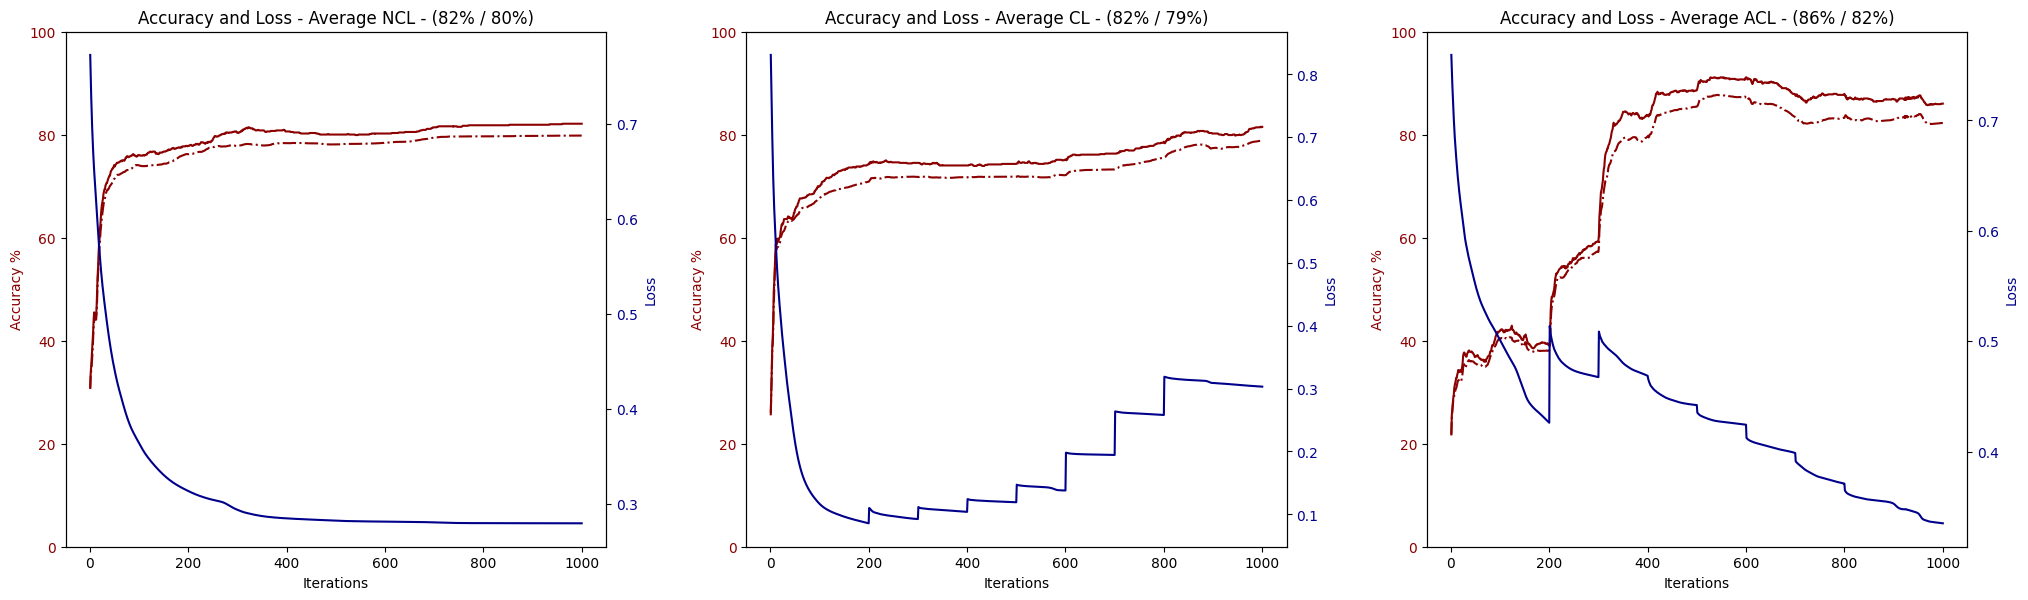

In [391]:
nqubits = 8
num_iters = 1000
num_runs = 10
time_now = "2024-01-30 22-55-44"

file_names = ["NCL","CL","ACL"]


fig, axis = plt.subplots(1,3)
fig.set_figheight(6)
fig.set_figwidth(20)
fig.tight_layout(pad=2, w_pad=7)

i = 0
for file_name in file_names:

        folder_name = f"Results/{nqubits}q - {num_iters:} iters"
        data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"

        # Read the saved data #####################
        read_data = pd.read_csv(data_file_name,
                                usecols=["losses",
                                        "acc_train",
                                        "acc_val"],
                                converters={"losses":ast.literal_eval,
                                        "acc_train":ast.literal_eval,
                                        "acc_val":ast.literal_eval})

        all_runs_losses = map(np.array, read_data["losses"])
        all_runs_acc_train = map(np.array, read_data["acc_train"])
        all_runs_acc_val = map(np.array, read_data["acc_val"])

        # We take the averages
        losses = sum(all_runs_losses)/num_runs
        acc_train = sum(all_runs_acc_train)/num_runs
        acc_val = sum(all_runs_acc_val)/num_runs

        iterations = range(1, num_iters+1)

        color1 = 'darkred'
        axis[i].set_xlabel('Iterations')
        axis[i].set_ylabel('Accuracy %', color=color1)
        axis[i].plot(iterations, acc_train, label="Training", color=color1)
        axis[i].plot(iterations, acc_val, '-.', label="Validation", color=color1)
        axis[i].tick_params(axis='y', labelcolor=color1)
        axis[i].set_ylim(0,100)

        ax2 = axis[i].twinx()  # instantiate a second axes that shares the same x-axis

        color2 = 'darkblue'
        ax2.set_ylabel('Loss', color=color2)  # we already handled the x-label with axis[0]
        ax2.plot(iterations, losses, label="Loss", color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        # ax2.set_ylim(bottom=0)

        # fig.tight_layout()  # otherwise the right y-label is slightly clipped
        # plt.legend()
        axis[i].set_title(f"Accuracy and Loss - Average {file_name} - ({round(acc_train[num_iters-1])}% / {round(acc_val[num_iters-1])}%)")
        
        i += 1
        
plt.show()
        
